# Getting Data

In [62]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [63]:
client_id = 'b05478021f3c4e73bbbd0482e81a3396'
client_secret = '535562f03be14a998dcd97448d5322e8'

#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [120]:
# Chill Car - Rap, Bollywood Beats, Lit Songs, Fam Mix, Chill - Pop, Nostalgia, Epic Vibes, Nostalgic EDM 
playlist_links = {"https://open.spotify.com/playlist/39yrrZvXXVTQjnv41mLZE5?si=043d2b062b4748c7",
                  "https://open.spotify.com/playlist/12p5ArAxY6r3QOtNATi7Mx?si=0e44c2c5c12d4f45",
                  "https://open.spotify.com/playlist/4KhumTd9QyJM3RUvAzSJh7?si=edc7bcc04f1c43a9",
                  "https://open.spotify.com/playlist/1OzHjXm9IwK7dlQk1mXP2N?si=05d4cd76d85f47df",
                  "https://open.spotify.com/playlist/2W4rSltujQSUyXT3Yu03ga?si=7ff0dd18a47b4517",
                  "https://open.spotify.com/playlist/4Xwamd29v8Lij8tsP9jslm?si=8ed5a2c219624e3c",
                  "https://open.spotify.com/playlist/2K1GpNap0DQs2BsTwbGGPI?si=bcea1ac135924f04",
                  "https://open.spotify.com/playlist/0KAbqWJrRxqhaoYKVu2hDE?si=0ebdb168c8634f40"
                  }
playlist_URIs = [playlist_link.split("/")[-1].split("?")[0] for playlist_link in playlist_links]

In [121]:
song_data = []
seen_songs = set()
for playlist_URI in playlist_URIs:
    for track in sp.playlist_tracks(playlist_URI)["items"]:
        
        # URI
        track_uri = track["track"]["uri"]
        
        # Skip duplicate songs
        if track_uri in seen_songs:
            # Update the playlist URIs for the existing song
            existing_song_index = next((index for index, song in enumerate(song_data) if song[0] == track_uri), None)
            if existing_song_index is not None:
                song_data[existing_song_index][-1].add(playlist_URI)
            continue
        
        # Add song URI to seen_songs set
        seen_songs.add(track_uri)
        
        # Track name
        track_name = track["track"]["name"]
        
        # Main Artist
        artist_uri = track["track"]["artists"][0]["uri"]
        artist_info = sp.artist(artist_uri)
        
        # Name, popularity, genre
        artist_name = track["track"]["artists"][0]["name"]
        artist_pop = artist_info["popularity"]
        artist_genres = artist_info["genres"]
        
        # Album
        album = track["track"]["album"]["name"]
        
        # release date
        release_date = track["track"]["album"]["release_date"][0:3]

        # Popularity of the track
        track_pop = track["track"]["popularity"]
        
        # Audio Features
        audio_features = sp.audio_features(track_uri)[0]
        selected_features = {
            'danceability': audio_features['danceability'],
            'energy': audio_features['energy'],
            'key': audio_features['key'],
            'loudness': audio_features['loudness'],
            'speechiness': audio_features['speechiness'],
            'acousticness': audio_features['acousticness'],
            'instrumentalness': audio_features['instrumentalness'],
            'liveness': audio_features['liveness'],
            'valence': audio_features['valence'],
            'tempo': audio_features['tempo']
        }
        
        song_data.append([track_name, artist_name, artist_genres, track_pop, release_date] + list(selected_features.values()) + [{playlist_URI}])

# Create the dataframe
columns = ['Track Name', 'Artist Name', 'Artist Genres', 'Track Popularity', 'Release Date'] + list(selected_features.keys()) + ['Playlist URIs']
df = pd.DataFrame(song_data, columns=columns)

# Exploring Data

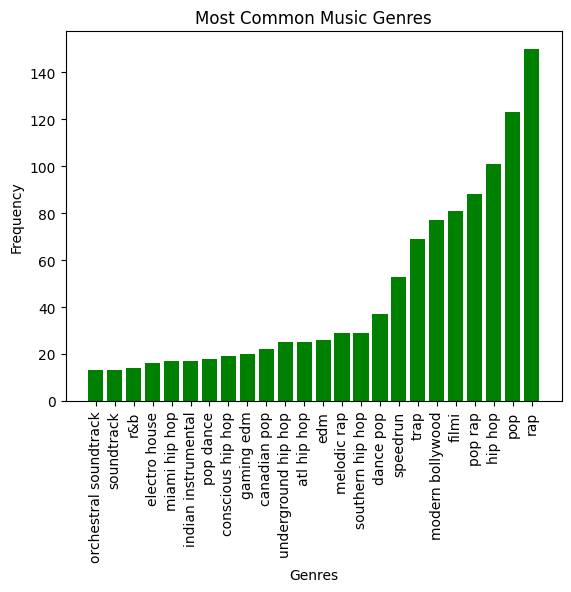

In [126]:
import matplotlib.pyplot as plt

genre_freq = {}

for genre_list in df['Artist Genres']:
    for g in genre_list:
        if g in genre_freq:
            genre_freq[g] += 1
        else:
            genre_freq[g] = 0

sorted_data = dict(sorted(genre_freq.items(), key=lambda x: x[1]))

genre_freq_filtered = {genre: frequency for genre, frequency in sorted_data.items() if frequency > 10}

plt.bar(genre_freq_filtered.keys(), genre_freq_filtered.values(), color='g')

# Set labels and title
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Most Common Music Genres')

# Rotate the genre labels for better visibility
plt.xticks(rotation=90)

# Display the histogram
plt.show()

# Processing

In [130]:
import re

for index, row in df.iterrows():
    genre_list = row['Artist Genres']

    rapPattern = '|'.join(['hip hop', 'rap'])
    popPattern = '|'.join(['pop', 'dance'])

    if 'edm' in genre_list:
        print(row['Artist Name'])
    # if 'filmi' in genre_list or 'modern bollywood' in genre_list:
    #     df.at[index, 'Artist Genres'] = 'bollywood'
    # elif re.search(rapPattern, str(genre_list), re.IGNORECASE) is not None:
    #     df.at[index, 'Artist Genres'] = 'rap'
    # elif re.search(popPattern, str(genre_list), re.IGNORECASE) is not None:
    #     df.at[index, 'Artist Genres'] = 'pop'

DVBBS
DVBBS
AFROJACK
Martin Garrix
Martin Garrix
Dimitri Vegas & Like Mike
R3HAB
Calvin Harris
Calvin Harris
Calvin Harris
Avicii
Tiësto
Martin Garrix
Zedd
Calvin Harris
Vicetone
Marshmello
Calvin Harris
Marshmello
Avicii
Jack Ü
Kygo
Avicii
DJ Snake
Marshmello
Diplo
Carnage


# Visualize

In [68]:
from sklearn.decomposition import PCA
pca_song = PCA(n_components=3)
principalComponents_songs = pca_song.fit_transform(x)

NameError: name 'x' is not defined